# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

### Change amount of memory

In [1]:
from pyspark import SparkContext

In [2]:
try:
    SparkContext.stop(sc)
except:
    pass
SparkContext.setSystemProperty('spark.executor.memory', '4g')
SparkContext.setSystemProperty('spark.executor.instances', '4')
sc = SparkContext("local", "Project3")

In [3]:
sc._conf.getAll()

[('spark.master', 'local'),
 ('spark.app.name', 'Project3'),
 ('spark.executor.instances', '4'),
 ('spark.driver.host', '52d3c212.dynamic-ip.k-net.dk'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1575481412558'),
 ('spark.executor.memory', '4g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '33559'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

### Imports

In [4]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *

spark = SparkSession.builder.appName("Project3").getOrCreate()

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

In [6]:
plt.style.use('seaborn')  # Just changes plotting theme, comment out if annoying\n
matplotlib.rcParams['figure.figsize'] = [14, 8]

### Utility Functions

In [7]:
def disp(x, n=10):
    """ Prettier spark dataframe printing with pandas
        Args:
            x: dataframe
            n: number of rows to display
    """
    return x.limit(n).toPandas().head(n)

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [8]:
data_path = '/home/zach/Data/airbnb/'

In [9]:
def read(path, f):
    return spark.read.option('inferSchema', True).option('multiline', True).csv(path+f, escape='"', header=True)

def read_parquet(path, f):
    return spark.read.parquet(path+f)

In [10]:
# listings = read(data_path, 'listings.csv')
listings = read_parquet(data_path, 'listings.parquet')

Pandas display much more useful because of horizontal scrolling

In [11]:
disp(listings)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,property_type
0,32802427,https://www.airbnb.com/rooms/32802427,20190923212307,2019-09-24,Rio vue d’en haut loin du bruit de la ville,Situé dans le quartier pitoresque et bucolique...,None,Situé dans le quartier pitoresque et bucolique...,none,Longtemps habité par les ambassades européenne...,...,f,flexible,f,f,1,0,1,0,None,Apartment
1,33579648,https://www.airbnb.com/rooms/33579648,20190916233617,2019-09-18,Superbe apt lumineux avec cachet Bonne Nouvelle,Beautiful apartment of 39 square meters locate...,The accommodation is fully equipped and will p...,Beautiful apartment of 39 square meters locate...,none,None,...,f,moderate,f,f,1,1,0,0,2.13,Apartment
2,32808959,https://www.airbnb.com/rooms/32808959,20190923212307,2019-09-24,Omar do Rio - CobR,None,"Welcome to Rio, Come and enjoy Rio de Janeiro ...","Welcome to Rio, Come and enjoy Rio de Janeiro ...",none,None,...,f,strict_14_with_grace_period,f,f,38,37,0,0,0.33,Apartment
3,33579730,https://www.airbnb.com/rooms/33579730,20190916233617,2019-09-17,Cosy & Trendy Parisian Flat in Le Marais,"A charming, cosy and romantic flat with a good...",The flat includes a beautiful main room with o...,"A charming, cosy and romantic flat with a good...",none,"The "" Nord Marais"" is one of the most popular ...",...,f,strict_14_with_grace_period,f,f,1,1,0,0,3.80,Apartment
4,32809224,https://www.airbnb.com/rooms/32809224,20190923212307,2019-09-24,Omar do Rio - BR902,None,"Welcome to Rio, Come and enjoy Rio de Janeiro ...","Welcome to Rio, Come and enjoy Rio de Janeiro ...",none,None,...,f,strict_14_with_grace_period,f,f,38,37,0,0,0.65,Apartment
5,33580065,https://www.airbnb.com/rooms/33580065,20190916233617,2019-09-18,"3 pièces, calme, rénové, bien situé","Trois pièces 65 m2, 3ème étage, bâtiment pierr...",Deux chambres équipées d'un lit deux places. P...,"Trois pièces 65 m2, 3ème étage, bâtiment pierr...",none,"Quartier agréable et tranquille, animé par des...",...,f,flexible,f,f,1,1,0,0,0.81,Apartment
6,32810193,https://www.airbnb.com/rooms/32810193,20190923212307,2019-09-24,Localização perfeita para quem quer comodidade,"Um apartamento de 50 mt, com com quarto e sala...",Está bem centralizado no coração de Copacaba...,"Um apartamento de 50 mt, com com quarto e sala...",none,Copacabana por si só já diz tudo. Lugar aco...,...,f,flexible,f,f,2,2,0,0,None,Apartment
7,33580395,https://www.airbnb.com/rooms/33580395,20190916233617,2019-09-18,☀️T2 Parc des expositions - 4 pers - Paris 15☀️ 2,Come discover my large apartment (31m2) renova...,"You will enjoy a quiet accommodation, without ...",Come discover my large apartment (31m2) renova...,none,The apartment is located two minutes walk from...,...,f,moderate,f,f,4,4,0,0,2.57,Apartment
8,32813881,https://www.airbnb.com/rooms/32813881,20190923212307,2019-09-24,"Copacabana 1 block from beach - best area, est...",Here you will be very well located in a very c...,This charming and quiet apartment is a 30sqm s...,Here you will be very well located in a very c...,none,Copacabana is the most famous district of Rio ...,...,f,strict_14_with_grace_period,f,f,7,7,0,0,1.74,Apartment
9,33580503,https://www.airbnb.com/rooms/33580503,20190916233617,2019-09-18,☀️Studio - Parc Exposition - 2 pers - Paris 15...,Come discover my apartment (19m2) renovated in...,"You will enjoy a quiet accommodation, without ...",Come discover my apartment (19m2) renovated in...,none,The apartment is located two minutes walk from...,...,f,moderate,f,f,4,4,0,0,1.89,Apartment


In [11]:
#reviews = read(data_path, 'reviews.csv')
reviews = read_parquet(data_path, 'reviews.parquet')

In [24]:
disp(reviews, 10)
#reviews.show(vertical=True, n=1)

,listing_id,id,reviewer_id,reviewer_name,comments,date,year_month
0,19630677,300367868,149216056,Stefanos,Good place. Good location.,2018-08-02,2026
1,19630677,302196799,142279610,Ειρηνη,Κουκλίστικη κατοικία στο πιο κεντρικό και ζωηρ...,2018-08-05,2026
2,19630677,303708873,149050314,Geir Angell,Charming apartment. Perfect host.,2018-08-08,2026
3,19630677,314716848,135746703,Christos,The host was absolutely amazing! The photos do...,2018-08-27,2026
4,19630677,481637214,3351829,Stoddard,Fantastic little place in a great location. E...,2019-07-05,2026
5,19630677,482982358,8915248,Melea,We had a lovely time staying at this place! Ho...,2019-07-07,2026
6,19630677,485608052,22209673,Elena,Thank you very much!,2019-07-11,2026
7,19630677,488537413,101927928,Ryan,Evangelos place was a great location and he me...,2019-07-15,2026
8,19630677,490238848,133986908,Chenli,"公寓就在老城里面,距离海边咫尺之遥,房间和描述的一样,房东回复很及时｡",2019-07-18,2026
9,19630677,493284596,256167996,John,"Very friendly host, the facilities were really...",2019-07-22,2026


### Describe the data
List the features (schema) and sizes of the datasets.

In [17]:
reviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [18]:
reviews.count()

32297300

In [23]:
listings.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [24]:
listings.count()

1330479

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

### Steps
1. Fix up  dates
2. Write to parquet: compresses reviews (9.5GB $\to$ 5.6GB), listings (5.0GB $\to$ 2.1GB)

In [12]:
reviews = reviews.withColumnRenamed('date', 'date_str')\
    .withColumn('date', f.to_date(f.col('date_str')))\
    .drop('date_str')

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

In [13]:
listings_agg = listings.groupBy('city')\
    .agg(f.countDistinct('neighbourhood').alias('nneighbourhoods'), \
         f.count('id').alias('nlistings')).sort(f.desc('nlistings'))
listings_agg.show()

+----------------+---------------+---------+
|            city|nneighbourhoods|nlistings|
+----------------+---------------+---------+
|           Paris|             63|    61923|
|  Greater London|            149|    46521|
|          London|            148|    33100|
|         Beijing|             61|    32339|
|     Los Angeles|             97|    27763|
|            Roma|             42|    25375|
|          Berlin|             93|    24271|
|       Cape Town|              0|    21896|
|         Toronto|            140|    21760|
|        New York|             98|    21457|
|       København|             21|    20800|
|          Madrid|             66|    20645|
|       Amsterdam|             44|    19956|
|       Barcelona|             68|    19873|
|  Rio de Janeiro|             93|    19322|
|        Brooklyn|             52|    18776|
|          Milano|             24|    17838|
|Ciudad de México|             55|    17814|
|        Montréal|             44|    16870|
|         

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [14]:
city = 'Boston'

In [15]:
types_and_hoods = listings.filter(f.col('city') == city)\
    .select('neighbourhood', 'property_type', 'id')\
    .groupBy('neighbourhood', 'property_type')\
    .count()\
    .orderBy(f.desc('count'))\

disp(types_and_hoods, 10)

,neighbourhood,property_type,count
0,Allston-Brighton,Apartment,352
1,Back Bay,Apartment,348
2,Fenway/Kenmore,Apartment,295
3,South End,Apartment,288
4,South Boston,Apartment,255
5,Downtown,Apartment,247
6,Dorchester,Apartment,246
7,Beacon Hill,Apartment,215
8,Jamaica Plain,Apartment,201
9,Roxbury,Apartment,200


Text(0.5, 1.0, 'Count of Top Property Types by Neighborhood')

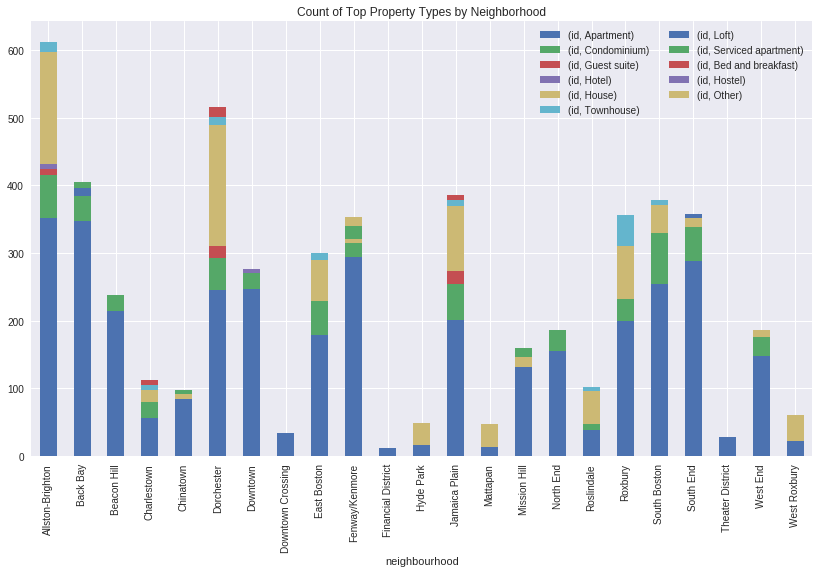

In [16]:
to_plot = listings.filter(f.col('city') == city)\
    .select('neighbourhood', 'property_type', 'id')\
    .toPandas()\
    .groupby(['neighbourhood', 'property_type'])\
    .count() \

ax = to_plot[to_plot.id > 5].unstack().plot(kind='bar', stacked=True)
fig = ax.get_figure()
plt.legend(loc='upper right', ncol=2)
plt.title('Count of Top Property Types by Neighborhood')

## Prices
Compute the minimum, maximum and average listing price in your city. 

In [17]:
def price_to_numeric(x):
    return float(x.replace(',', '')[1:])

p2numeric_udf = f.udf(price_to_numeric, FloatType())

In [18]:
city_df = listings.filter(f.col('city') == city).withColumn('price_float', p2numeric_udf(f.col('price')))
city_prices = city_df.agg(f.min('price_float'), 
                          f.avg('price_float'), 
                          f.max('price_float'), 
                          f.stddev_pop('price_float'))
disp(city_prices)

,min(price_float),avg(price_float),max(price_float),stddev_pop(price_float)
0,0.0,192.14723,10000.0,339.671922


Compute and visualize the distribution of listing prices in your city.

Text(0.5, 1.0, 'Price Histogram')

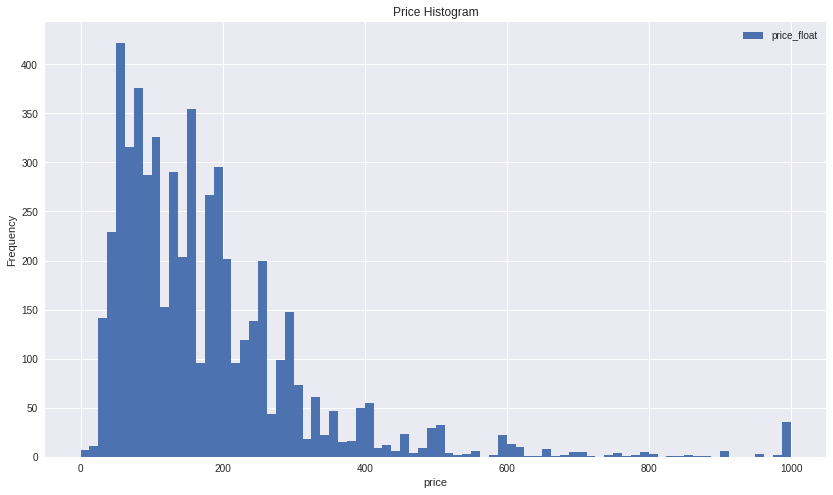

In [20]:
price_lim = 1000
ax = city_df.select('price_float').filter(f.col('price_float') < price_lim).toPandas().plot(kind='hist', bins=80)
ax.set_xlabel('price')
ax.set_title('Price Histogram')

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [21]:
city_w_value = city_df.withColumn('value', f.round(f.col('review_scores_rating')/f.col('price_float'), 2))

In [22]:
values_window = Window.partitionBy('neighbourhood').orderBy(f.desc('value'))

ranked_values = city_w_value.withColumn('ValueRank', f.rank().over(values_window))
ranked_values = ranked_values.filter(f.col('ValueRank') <= 3)\
    .select('id', 'neighbourhood', 'review_scores_rating', 'price_float', 'value')\
    .orderBy('neighbourhood', f.desc('value'))\

disp(ranked_values)

,id,neighbourhood,review_scores_rating,price_float,value
0,34480993,Allston-Brighton,93,10.0,9.30
1,34450964,Allston-Brighton,86,10.0,8.60
2,19779706,Allston-Brighton,86,10.0,8.60
3,26885536,Back Bay,93,40.0,2.33
4,32861088,Back Bay,88,65.0,1.35
5,32241248,Back Bay,100,85.0,1.18
6,23502542,Beacon Hill,97,50.0,1.94
7,2862120,Beacon Hill,95,50.0,1.90
8,23563583,Beacon Hill,90,59.0,1.53
9,32939145,Cambridge,98,234.0,0.42


## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

In [97]:
city_review = city_df.select('neighbourhood', 'property_type', f.col('id').alias('id_'))\
    .join(reviews, (reviews.listing_id == f.col('id_')), 'inner')\
    .drop('id_')

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

In [98]:
pop_months = city_review.groupby(f.month('date')).count().orderBy('month(date)')

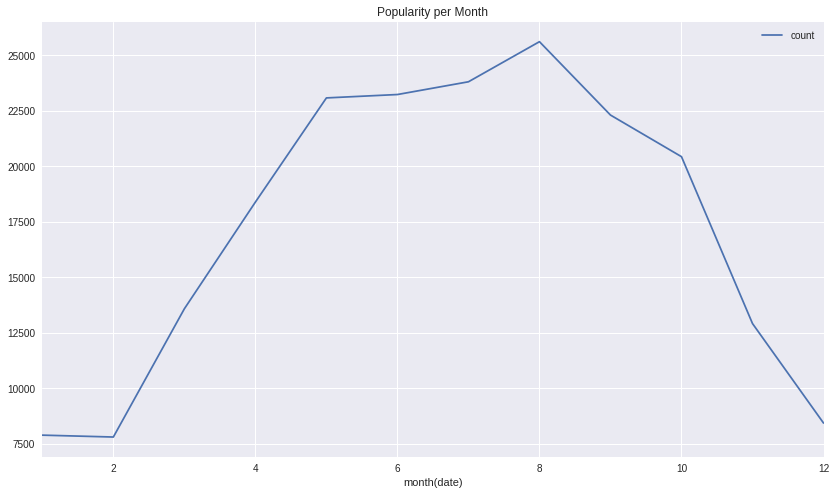

In [99]:
pop_months.toPandas().plot(kind='line', x='month(date)', y='count', title="Popularity per Month")

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

In [100]:
pop_over_time = city_review.select('neighbourhood', 'date')\
    .groupby('neighbourhood', f.year('date')).count().orderBy('neighbourhood', 'year(date)')

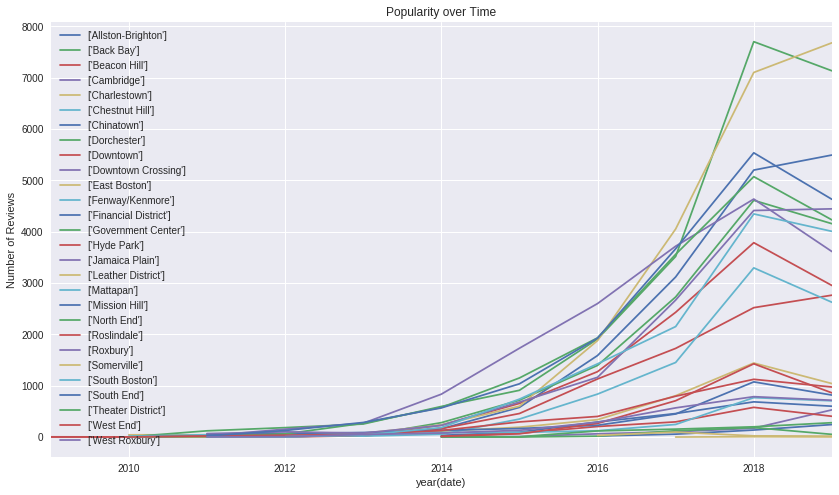

In [101]:
fig, ax = plt.subplots()
to_plot2 = pop_over_time.toPandas().groupby('neighbourhood')
to_plot2.plot(kind='line', 
              x = 'year(date)',
              label='neighbourhood',
              ax=ax,
              title="Popularity over Time")
plt.ylabel('Number of Reviews')
plt.legend(to_plot2.neighbourhood.unique())

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

## Approach
The approach here is to assign each word a cumulative score based on the reviews it occurs in. First, a Pyspark tokenizer is used to separate individual words from sentences. Next, in order to center scores around zero, the [z-score](https://en.wikipedia.org/wiki/Standard_score) of the 1-5 star rating is taken. This z-score for each review is then assigned to all words in that review. Finally, the sum of scores for each individual word is calculated and the sums are sorted in descending order to get the most positive words.

In [12]:
reviews_scores = listings.select('review_scores_rating', 'id').join(reviews, listings.id == reviews.listing_id).drop('id')
reviews_scores = reviews_scores.withColumn("Scores", f.col("review_scores_rating").cast(IntegerType()))

In [13]:
stats = reviews_scores.select('Scores').agg(f.mean('Scores').alias('avg'),  \
    f.stddev_pop('Scores').alias('sd'))\
    .toPandas()
avg, sd = stats['avg'][0], stats['sd'][0]

In [14]:
reviews_scores = reviews_scores.withColumn("z-score", (f.col('Scores') - avg) / sd)

In [15]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

In [16]:
tokenizer = Tokenizer(inputCol="comments", outputCol="words")
tokenized = tokenizer.transform(reviews_scores)

In [17]:
disp(tokenized)

,review_scores_rating,listing_id,reviewer_id,reviewer_name,comments,date,year_month,Scores,z-score,words
0,90,10012138,277188463,Delmi,I would highly recommend this place!! It’s an ...,2019-07-27,2026,90,-1.041658,"[i, would, highly, recommend, this, place!!, i..."
1,90,10012138,96462574,OM Sanctuary,"Great location, right on the beach, wonderful ...",2016-11-15,2027,90,-1.041658,"[great, location,, right, on, the, beach,, won..."
2,90,10012138,25412112,Jimmy,The condo was very roomy as described. The mas...,2019-03-12,2022,90,-1.041658,"[the, condo, was, very, roomy, as, described.,..."
3,90,10012138,372236,Juliet,Marco’s place was great! Very clean & great lo...,2018-03-27,2021,90,-1.041658,"[marco’s, place, was, great!, very, clean, &, ..."
4,84,10023519,40524464,Fernando,Great place to stay at.,2017-09-16,2026,84,-2.353462,"[great, place, to, stay, at.]"
5,84,10023519,70998709,B. Ben,Host was very accommodating. Always ready to h...,2016-06-26,2022,84,-2.353462,"[host, was, very, accommodating., always, read..."
6,84,10023519,130532853,Phon,So far is good. \nGood location. \n,2017-05-26,2022,84,-2.353462,"[so, far, is, good., , good, location.]"
7,84,10023519,92535971,Khai Yih,Everything is good except the blanket too thin...,2016-09-01,2025,84,-2.353462,"[everything, is, good, except, the, blanket, t..."
8,84,10023519,90186719,Miha,"Clean, cozy, very friendly staff. Also very co...",2016-09-04,2025,84,-2.353462,"[clean,, cozy,, very, friendly, staff., also, ..."
9,84,10023519,81116955,Héléna,Good experience.,2016-09-05,2025,84,-2.353462,"[good, experience.]"


In [18]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered = remover.transform(tokenized)

In [19]:
filtered = filtered.withColumn('word', f.explode('filtered_words')).select('z-score', 'word')

In [20]:
disp(filtered)

,z-score,word
0,-1.041658,highly
1,-1.041658,recommend
2,-1.041658,place!!
3,-1.041658,it’s
4,-1.041658,amazing
5,-1.041658,place
6,-1.041658,stay.
7,-1.041658,secure
8,-1.041658,key
9,-1.041658,fob


In [21]:
positive_ranking = filtered.groupby('word').sum().orderBy(f.desc('sum(z-score)'))

In [22]:
pd_positive_words = positive_ranking.limit(1000).toPandas()

Py4JJavaError: An error occurred while calling o220.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 15.0 failed 1 times, most recent failure: Lost task 0.0 in stage 15.0 (TID 745, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$createTransformFunc$1: (string) => array<string>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$15$$anon$2.hasNext(WholeStageCodegenExec.scala:655)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$JoinIterator.hasNext(Iterator.scala:212)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.feature.Tokenizer$$anonfun$createTransformFunc$1.apply(Tokenizer.scala:39)
	at org.apache.spark.ml.feature.Tokenizer$$anonfun$createTransformFunc$1.apply(Tokenizer.scala:39)
	... 21 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1035)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1017)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1.apply(RDD.scala:1439)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1426)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:136)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$createTransformFunc$1: (string) => array<string>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$15$$anon$2.hasNext(WholeStageCodegenExec.scala:655)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$JoinIterator.hasNext(Iterator.scala:212)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.feature.Tokenizer$$anonfun$createTransformFunc$1.apply(Tokenizer.scala:39)
	at org.apache.spark.ml.feature.Tokenizer$$anonfun$createTransformFunc$1.apply(Tokenizer.scala:39)
	... 21 more


In [ ]:
pd_positive_words.head(20)